In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [2]:
!mamba install -y -c rapidsai -c conda-forge -c nvidia \
    cuml=23.12 python=3.10 cudatoolkit=11.8


Looking for: ['cuml=23.12', 'python=3.10', 'cudatoolkit=11.8']

rapidsai/linux-64                                           Using cache
rapidsai/noarch                                             Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
nvidia/linux-64                                             Using cache
nvidia/noarch                                               Using cache
Your pinning does not match what's currently installed. Please remove the pin and fix your installation
  Pin: python=3.12
  Currently installed: conda-forge/linux-64::python==3.11.11=h9e4cc4f_1_cpython


In [3]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from cuml.svm import SVC
import cupy as cp
from cuml.svm import LinearSVC
import gc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Χ_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_Test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Χ_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_Test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [5]:
# Reshaping των features και των labels

X_train_reshaped = x_train.reshape(len(x_train), -1).astype(np.float32) / 255.0
X_test_reshaped  = x_test.reshape(len(x_test),  -1).astype(np.float32) / 255.0

y_train_reshaped = y_train.reshape(-1)
y_test_reshaped  = y_test.reshape(-1)

print("X_Train shape:", X_train_reshaped.shape)
print("y_Train shape:", y_train_reshaped.shape)
print("Test :", X_test_reshaped.shape)
print("Train:", y_test_reshaped.shape)

X_Train shape: (50000, 3072)
y_Train shape: (50000,)
Test : (10000, 3072)
Train: (10000,)


In [6]:
# 20% Validation set
# 40.000 train / 10.000 Validation
# Stratify για ομοιο καταμοιρασμο, δλδ 10 κλασεις -> 1.000 εικονες απο καθε κλαση στο validation

X_tr, X_val, y_tr, y_val = train_test_split(X_train_reshaped, y_train_reshaped, test_size=0.2, random_state=42, stratify=y_train_reshaped)

print("X_train shape:", X_tr.shape)
print("y_train shape:", y_tr.shape)
print("X_validation shape:", X_val.shape)
print("y_validation shape:", y_val.shape)

X_train shape: (40000, 3072)
y_train shape: (40000,)
X_validation shape: (10000, 3072)
y_validation shape: (10000,)


In [7]:
# Κανονικοποιηση: z=(x-μ)/σ

scaler = StandardScaler()

X_tr_sc = scaler.fit_transform(X_tr)     # fit: Βρισκει το μεσο ορο μ και την τυπικη αποκλιση σ των δεδομενων εκπαιδευσης  |  transform: Εφαρμοζει z=(x-μ)/σ
X_val_sc = scaler.transform(X_val)       # Μονο transform με μ και σ των δεδομενων εκπαιδευσης (X_tr)
X_test_sc = scaler.transform(X_test_reshaped)   # Ομοιως μονο transform. Αν εκανα fit και στο val και στο test, θα εβρισκα μ και σ του train+val / train+test, δηλαδη θα τα θεωρουσα σαν δεδομ. εκπαιδευσης, που ειναι λαθος

print("X_tr_sc mean:", X_tr_sc.mean(), ", X_tr_sc std:", X_tr_sc.std())
print("X_val_sc mean:", X_val_sc.mean(),", X_val_sc std:", X_val_sc.std())
print("X_test_sc mean:", X_test_sc.mean(), ", X_test_sc std:", X_test_sc.std())

X_tr_sc mean: -2.870212e-09 , X_tr_sc std: 0.9999999
X_val_sc mean: 0.0016839259 , X_val_sc std: 0.9987574
X_test_sc mean: 0.013206028 , X_test_sc std: 0.99827


In [8]:
# PCA

pca = PCA(n_components=0.90)
X_tr_pca  = pca.fit_transform(X_tr_sc)
X_val_pca = pca.transform(X_val_sc)
X_test_pca = pca.transform(X_test_sc)

In [9]:
# Μεταφορα δεδομενων σε GPU για το SVM της cumil

X_tr_gpu = cp.asarray(X_tr_pca)
y_tr_gpu = cp.asarray(y_tr)

X_val_gpu = cp.asarray(X_val_pca)
y_val_gpu = cp.asarray(y_val)

X_test_full_gpu = cp.asarray(X_test_pca)
y_test_full_gpu = cp.asarray(y_test_reshaped)

print(X_tr_gpu.shape, X_val_gpu.shape, X_test_full_gpu.shape)
print(X_tr_gpu.dtype, X_test_full_gpu.dtype)

(40000, 102) (10000, 102) (10000, 102)
float32 float32


In [10]:
# Συναρτηση που εκπαιδευει (fit), κανει προβλεψη (predict), και βρισκει τους χρονους για το καθενα

def train_eval(model, X_tr, y_tr, X_val, y_val, name="Model"):
    print(f"Training {name}...")

    # Χρονομετρηση
    start = time.time()

    # Εκπαιδευση
    model.fit(X_tr, y_tr)
    train_time = time.time() - start    # Χρονος εκπαιδευσης

    # Προβλεψη train και validation
    print("Evaluating model...")
    pred_tr  = model.predict(X_tr)
    pred_val = model.predict(X_val)
    prediction_time = time.time() - start

    # Μετατροπη προβλεψεων σε numpy array data επειδη accuracy_score -> sklearn -> χρησιμοποιει CPU

    acc_tr  = accuracy_score(cp.asnumpy(y_tr), cp.asnumpy(pred_tr))
    acc_val = accuracy_score(cp.asnumpy(y_val), cp.asnumpy(pred_val))

    print(f" Train accuracy: {acc_tr:.4f}")
    print(f" Val accuracy: {acc_val:.4f}")
    print(f"\n Train time: {train_time:.2f}s")
    print(f" Prediction time: {prediction_time:.2f}s")



# **LINEAR KERNEL**

In [ ]:
svm_lin = LinearSVC(C=1.0, max_iter=2000)
train_eval(svm_lin, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, "LinearSVC (C=1)")

Training LinearSVC (C=1)...
Evaluating model...
 Train accuracy: 0.3982
 Val accuracy: 0.3929

 Train time: 0.40s
 Prediction time: 0.40s


In [ ]:
svm_lin = LinearSVC(C=10.0, max_iter=2000)
train_eval(svm_lin, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, "LinearSVC (C=10)")

Training LinearSVC (C=10)...
Evaluating model...
 Train accuracy: 0.3984
 Val accuracy: 0.3928

 Train time: 0.39s
 Prediction time: 0.40s


In [ ]:
svm_lin = LinearSVC(C=0.1, max_iter=2000)
train_eval(svm_lin, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, "LinearSVC (C=0.1)")

Training LinearSVC (C=0.1)...
Evaluating model...
 Train accuracy: 0.3982
 Val accuracy: 0.3932

 Train time: 0.39s
 Prediction time: 0.40s


In [ ]:
svm_lin = LinearSVC(C=100.0, max_iter=2000)
train_eval(svm_lin, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, "LinearSVC (C=100)")

Training LinearSVC (C=100)...
Evaluating model...
 Train accuracy: 0.3983
 Val accuracy: 0.3928

 Train time: 0.40s
 Prediction time: 0.40s


# **POLYNOMIAL KERNEL**

In [ ]:
svm_poly2 = SVC(kernel="poly", degree=2, C=1.0)

train_eval(svm_poly2, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=2, C=1)")

Training SVM with polynomial Kernel (d=2, C=1)...
Evaluating model...
 Train accuracy: 0.5495
 Val accuracy: 0.4621

 Train time: 5.55s
 Prediction time: 24.08s


In [ ]:
svm_poly3 = SVC(kernel="poly", degree=3, C=1.0)

train_eval(svm_poly3, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=3, C=1)")

Training SVM with polynomial Kernel (d=3, C=1)...
Evaluating model...
 Train accuracy: 0.6547
 Val accuracy: 0.4653

 Train time: 6.63s
 Prediction time: 26.87s


In [ ]:
svm_poly4 = SVC(kernel="poly", degree=4, C=1.0)

train_eval(svm_poly4, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=4, C=1)")

Training SVM with polynomial Kernel (d=4, C=1)...
Evaluating model...
 Train accuracy: 0.6372
 Val accuracy: 0.3823

 Train time: 7.56s
 Prediction time: 30.54s


In [ ]:
svm_poly3 = SVC(kernel="poly", degree=3, C=10.0)

train_eval(svm_poly3, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=3, C=10)")

Training SVM with polynomial Kernel (d=3, C=10)...
Evaluating model...
 Train accuracy: 0.9072
 Val accuracy: 0.4756

 Train time: 18.62s
 Prediction time: 35.62s


In [ ]:
del svm_poly2, svm_poly3, svm_poly4
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_poly3 = SVC(kernel="poly", degree=3, C=100.0)

train_eval(svm_poly3, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=3, C=100)")

Training SVM with polynomial Kernel (d=3, C=100)...
Evaluating model...
 Train accuracy: 0.9919
 Val accuracy: 0.4561

 Train time: 35.31s
 Prediction time: 50.57s


In [ ]:
del  svm_poly3
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_poly3 = SVC(kernel="poly", degree=3, C=40.0)

train_eval(svm_poly3, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=3, C=40)")

Training SVM with polynomial Kernel (d=3, C=40)...
Evaluating model...
 Train accuracy: 0.9760
 Val accuracy: 0.4658

 Train time: 29.18s
 Prediction time: 44.99s


In [ ]:
svm_poly3 = SVC(kernel="poly", degree=3, C=40.0, coef0=1)

train_eval(svm_poly3, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with polynomial Kernel (d=3, C=40, coef0=1)")

Training SVM with polynomial Kernel (d=3, C=40, coef0=1)...
Evaluating model...
 Train accuracy: 0.9957
 Val accuracy: 0.5201

 Train time: 46.22s
 Prediction time: 57.59s


In [ ]:
del  svm_poly3
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

# **RBF KERNEL**

 **Χειροκινητα γ**

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.1)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.1)")

Training SVM with RBF Kernel (C=1, γ=0.1)...
Evaluating model...
 Train accuracy: 1.0000
 Val accuracy: 0.1035

 Train time: 2.90s
 Prediction time: 14.95s


In [ ]:
svm_rbf = SVC(kernel="rbf", C=10.0, gamma=0.1)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=10, γ=0.1)")

Training SVM with RBF Kernel (C=10, γ=0.1)...
Evaluating model...
 Train accuracy: 1.0000
 Val accuracy: 0.1058

 Train time: 2.93s
 Prediction time: 14.88s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=1)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=1)")

Training SVM with RBF Kernel (C=1, γ=1)...
Evaluating model...
 Train accuracy: 1.0000
 Val accuracy: 0.1000

 Train time: 3.27s
 Prediction time: 15.26s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.01)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.01)")

Training SVM with RBF Kernel (C=1, γ=0.01)...
Evaluating model...
 Train accuracy: 1.0000
 Val accuracy: 0.1983

 Train time: 6.03s
 Prediction time: 17.45s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.001)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.001)")

Training SVM with RBF Kernel (C=1, γ=0.001)...
Evaluating model...
 Train accuracy: 0.8686
 Val accuracy: 0.5428

 Train time: 4.22s
 Prediction time: 11.40s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.0001)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.0001)")

Training SVM with RBF Kernel (C=1, γ=0.0001)...
Evaluating model...
 Train accuracy: 0.5126
 Val accuracy: 0.4808

 Train time: 2.43s
 Prediction time: 8.13s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=10.0, gamma=0.001)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel(C=10, γ=0.001)")

Training SVM with RBF Kernel(C=10, γ=0.001)...
Evaluating model...
 Train accuracy: 0.9980
 Val accuracy: 0.5551

 Train time: 6.52s
 Prediction time: 14.06s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=5.0, gamma=0.001)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=5, γ=0.001)")

Training SVM with RBF Kernel (C=5, γ=0.001)...
Evaluating model...
 Train accuracy: 0.9910
 Val accuracy: 0.5562

 Train time: 6.31s
 Prediction time: 13.95s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.005)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.005)")

Training SVM with RBF Kernel (C=1, γ=0.005)...
Evaluating model...
 Train accuracy: 0.9970
 Val accuracy: 0.2932

 Train time: 6.35s
 Prediction time: 17.42s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=10.0, gamma=0.0005)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel(C=10, γ=0.0005)")

Training SVM with RBF Kernel(C=10, γ=0.0005)...
Evaluating model...
 Train accuracy: 0.9714
 Val accuracy: 0.5516

 Train time: 8.54s
 Prediction time: 14.39s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=7.0, gamma=0.0007)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel(C=7, γ=0.0007)")

Training SVM with RBF Kernel(C=7, γ=0.0007)...
Evaluating model...
 Train accuracy: 0.9822
 Val accuracy: 0.5575

 Train time: 7.07s
 Prediction time: 13.64s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.004)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.004)")

Training SVM with RBF Kernel (C=1, γ=0.004)...
Evaluating model...
 Train accuracy: 0.9937
 Val accuracy: 0.3481

 Train time: 6.35s
 Prediction time: 17.24s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.0007)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=0.0007)")

Training SVM with RBF Kernel (C=1, γ=0.0007)...
Evaluating model...
 Train accuracy: 0.7905
 Val accuracy: 0.5495

 Train time: 3.70s
 Prediction time: 9.98s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

Μετα απο πολλες ακομα δοκιμες, βρηκα αυτο

In [ ]:
svm_rbf = SVC(kernel="rbf", C=2.1, gamma=0.00065)

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=2.1, γ=0.00065)")

Training SVM with RBF Kernel (C=2.1, γ=0.00065)...
Evaluating model...
 Train accuracy: 0.8907
 Val accuracy: 0.5600

 Train time: 5.07s
 Prediction time: 11.24s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

**γ = Scale**

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=1, γ=scale)")

Training SVM with RBF Kernel (C=1, γ=scale)...
Evaluating model...
 Train accuracy: 0.6592
 Val accuracy: 0.5360

 Train time: 3.01s
 Prediction time: 8.59s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=0.1, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=0.1, γ=scale)")

Training SVM with RBF Kernel (C=0.1, γ=scale)...
Evaluating model...
 Train accuracy: 0.4708
 Val accuracy: 0.4450

 Train time: 2.41s
 Prediction time: 9.25s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=10.0, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=10 γ=scale)")

Training SVM with RBF Kernel (C=10 γ=scale)...
Evaluating model...
 Train accuracy: 0.9398
 Val accuracy: 0.5536

 Train time: 9.67s
 Prediction time: 15.02s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=7.0, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=7, γ=scale)")

Training SVM with RBF Kernel (C=7, γ=scale)...
Evaluating model...
 Train accuracy: 0.9085
 Val accuracy: 0.5559

 Train time: 8.25s
 Prediction time: 13.56s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=5.0, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=5, γ=scale)")

Training SVM with RBF Kernel (C=5, γ=scale)...
Evaluating model...
 Train accuracy: 0.8718
 Val accuracy: 0.5565

 Train time: 7.10s
 Prediction time: 12.42s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_rbf = SVC(kernel="rbf", C=3.0, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=3, γ=scale)")

Training SVM with RBF Kernel (C=3, γ=scale)...
Evaluating model...
 Train accuracy: 0.8049
 Val accuracy: 0.5569

 Train time: 5.54s
 Prediction time: 10.86s


In [ ]:
del  svm_rbf
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

# **SIGMOID KERNEL**

In [ ]:
svm_sigm = SVC(kernel="sigmoid", C=1.0, gamma=0.1)

train_eval(svm_sigm, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with Sigmoid Kernel")

Training SVM with Sigmoid Kernel...
Evaluating model...
 Train accuracy: 0.1382
 Val accuracy: 0.1380

 Train time: 1.76s
 Prediction time: 4.37s


In [ ]:
del  svm_sigm
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_sigm = SVC(kernel="sigmoid", C=1.0, gamma="scale")

train_eval(svm_sigm, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with Sigmoid Kernel")

Training SVM with Sigmoid Kernel...
Evaluating model...
 Train accuracy: 0.2285
 Val accuracy: 0.2283

 Train time: 1.81s
 Prediction time: 4.25s


In [ ]:
del  svm_sigm
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_sigm = SVC(kernel="sigmoid", C=1.0, gamma="scale", coef0=1.0)
train_eval(svm_sigm, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM Sigmoid Kernel")

Training SVM Sigmoid Kernel...
Evaluating model...
 Train accuracy: 0.1366
 Val accuracy: 0.1336

 Train time: 1.66s
 Prediction time: 4.34s


In [ ]:
del  svm_sigm
gc.collect()

cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

In [ ]:
svm_sigm = SVC(kernel="sigmoid", C=10.0, gamma="scale")

train_eval(svm_sigm, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM Sigmoid Kernel")

Training SVM Sigmoid Kernel...
Evaluating model...
 Train accuracy: 0.2287
 Val accuracy: 0.2287

 Train time: 1.74s
 Prediction time: 4.07s


# **Evaluate Best SVM model on Test Set**

In [11]:
svm_rbf = SVC(kernel="rbf", C=5.0, gamma="scale")

train_eval(svm_rbf, X_tr_gpu, y_tr_gpu, X_val_gpu, y_val_gpu, name="SVM with RBF Kernel (C=5, γ=scale)")

Training SVM with RBF Kernel (C=5, γ=scale)...
Evaluating model...
 Train accuracy: 0.8718
 Val accuracy: 0.5565

 Train time: 10.36s
 Prediction time: 15.69s


In [12]:
print("Test evaluation...")

start = time.time()
pred_test = svm_rbf.predict(X_test_full_gpu)
test_time = time.time() - start

acc_test = accuracy_score(cp.asnumpy(y_test_full_gpu), cp.asnumpy(pred_test))

print(f"SVM RBF Test accuracy: {acc_test:.4f}")
print(f"Test prediction time: {test_time:.2f}s")

Test evaluation...
SVM RBF Test accuracy: 0.5535
Test prediction time: 1.27s


# **Confusion Matrix**

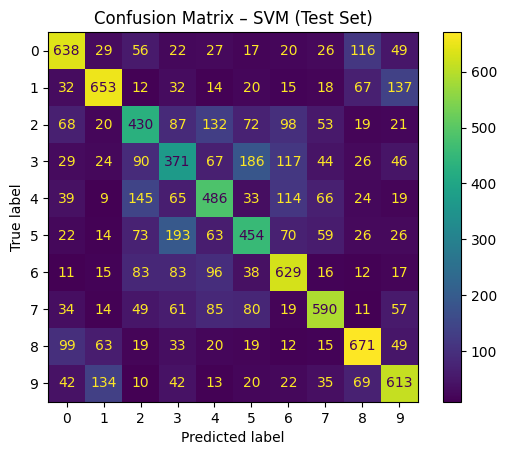

In [13]:
cm = confusion_matrix(y_test_reshaped, cp.asnumpy(pred_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix – SVM (Test Set)")
plt.show()